In [26]:
import pandas as pd
import numpy as np
import requests
import os 
from dotenv import load_dotenv
import requests
from tqdm import tqdm
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Input files

Base data file

In [2]:
with open('../data/pickle/dataset_usa_base.pickle', 'rb') as base_data:
    base_data = pickle.load(base_data)
print(base_data.shape)
base_data.head(1)

(455057, 9)


,title,rank,date,artist,url,region,chart,trend,streams
8246,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000


LastFM extraction

In [3]:
with open('../data/pickle/spotify_dataset_lastfm.pickle', 'rb') as data_lastfm:
    data_lastfm = pickle.load(data_lastfm)
data_lastfm.drop_duplicates(inplace=True)
print(data_lastfm.drop_duplicates().shape)
data_lastfm.head(1)

(14659, 17)


,url,artist,track,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4
8246,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,migos,bad and boujee (feat. lil uzi vert),"30 Jan 2018, 04:41","26 Jun 2013, 14:20","Migos is a rap trio-group from Lawrenceville, ...","Migos is a rap trio-group from Lawrenceville, ...",Hip-Hop,trap,rap,hip hop,atlanta,trap,Hip-Hop,rap,2010s,meme rap


Spotify extraction

In [4]:
with open('../data/pickle/spotify_dataset_audioFeatures.pickle', 'rb') as data_spotify:
    data_spotify = pickle.load(data_spotify)
data_spotify.drop_duplicates(inplace=True)
print(data_spotify.drop_duplicates().shape)
data_spotify.head(1)

(13989, 21)


,url,artist,track,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,migos,bad and boujee (feat. lil uzi vert),spotify:track:0M9ydKzuF3oZTfYYPfaGX1,0.926,0.666,11.000,-5.314,1.000,0.244,0.061,0.000,0.123,0.168,127.079,audio_features,0M9ydKzuF3oZTfYYPfaGX1,https://api.spotify.com/v1/tracks/0M9ydKzuF3oZ...,https://api.spotify.com/v1/audio-analysis/0M9y...,343150.000,4.000


# Merging all data

In [5]:
df = base_data.merge(data_lastfm, on = 'url', indicator = True, how = 'left')
df.value_counts('_merge')

_merge
both          456306
left_only          0
right_only         0
dtype: int64

In [6]:
df.drop(['_merge'], axis = 1, inplace = True)
df = df.merge(data_spotify, on = 'url', indicator = True, how = 'left')
df.value_counts('_merge')

_merge
both          442906
left_only      13924
right_only         0
dtype: int64

In [7]:
df.drop(['artist_y', 'track_x', 'artist', 'track_y', '_merge'], axis = 1, inplace= True)
df.rename({'artist_x':'artist'}, inplace=True, axis=1)
print(df.shape)
df.head(1)

(456830, 42)


,title,rank,date,artist,url,region,chart,trend,streams,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,_merge
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000,"30 Jan 2018, 04:41","26 Jun 2013, 14:20","Migos is a rap trio-group from Lawrenceville, ...","Migos is a rap trio-group from Lawrenceville, ...",Hip-Hop,trap,rap,hip hop,atlanta,trap,Hip-Hop,rap,2010s,meme rap,spotify:track:0M9ydKzuF3oZTfYYPfaGX1,0.926,0.666,11.000,-5.314,1.000,0.244,0.061,0.000,0.123,0.168,127.079,audio_features,0M9ydKzuF3oZTfYYPfaGX1,https://api.spotify.com/v1/tracks/0M9ydKzuF3oZ...,https://api.spotify.com/v1/audio-analysis/0M9y...,343150.000,4.000,both


# Most streamed artists

In [21]:
top10 = df.groupby(['artist'])['streams'].sum().reset_index().sort_values(by = 'streams', ascending = False).head(10)
top10['ratio'] = top10['streams'] * 100 / (df[~df['streams'].isnull()]['streams'].sum())
top10

,artist,streams,ratio
3638,Post Malone,4966682478.000,3.480
1293,Drake,4697961521.000,3.292
2273,Juice WRLD,4400300033.000,3.083
4923,XXXTENTACION,3436491646.000,2.408
587,Billie Eilish,2892423843.000,2.027
317,Ariana Grande,2501369300.000,1.753
4686,Travis Scott,2479590219.000,1.737
2719,Lil Uzi Vert,2430469669.000,1.703
4415,Taylor Swift,1961042065.000,1.374
2449,Khalid,1896097253.000,1.328


# Most streamed music genres

In [19]:
top10genre = df.groupby(['aritist_genre_0'])['streams'].sum().reset_index().sort_values(by = 'streams', ascending = False).head(10)
top10genre['ratio'] = top10genre['streams'] * 100 / (df[~df['streams'].isnull()]['streams'].sum())
top10genre[top10genre['ratio'] > 0]

,aritist_genre_0,streams,ratio
38,Hip-Hop,49791087055.000,34.885
278,pop,22384062153.000,15.683
293,rap,9273619419.000,6.497
336,trap,7036152233.000,4.930
296,rnb,6881614562.000,4.821
145,country,6809303174.000,4.771
166,electronic,2912358843.000,2.040
206,indie,2448856276.000,1.716
314,soul,1772419962.000,1.242
91,acoustic,1573034043.000,1.102


# Artist evolution

In [25]:
lista_artistas = list(top10['artist'])
df_top10 = df[df['artist'].isin(lista_artistas)]
df_top10.head()

,title,rank,date,artist,url,region,chart,trend,streams,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,_merge
1,Fake Love,2,2017-01-01,Drake,https://open.spotify.com/track/343YBumqHu19cGo...,United States,top200,SAME_POSITION,1180074.000,"27 Oct 2016, 02:34","25 Mar 2006, 06:09","Aubrey Drake Graham (born October 24, 1986) is...","Aubrey Drake Graham (born October 24, 1986) is...",Hip-Hop,rap,rnb,hip hop,Canadian,trap,Hip-Hop,rap,hiphop,rnb,spotify:track:343YBumqHu19cGoGARUTsd,0.928,0.481,9.000,-9.350,0.000,0.287,0.105,0.000,0.176,0.613,134.007,audio_features,343YBumqHu19cGoGARUTsd,https://api.spotify.com/v1/tracks/343YBumqHu19...,https://api.spotify.com/v1/audio-analysis/343Y...,210937.000,4.000,both
31,You Was Right,32,2017-01-01,Lil Uzi Vert,https://open.spotify.com/track/2ANLarE8yHVsLWW...,United States,top200,SAME_POSITION,401546.000,NaN,"21 Apr 2016, 19:11","Symere Bysil Woods (born July 31, 1995), known...","Symere Bysil Woods (born July 31, 1995), known...",trap,Hip-Hop,rap,hip hop,emo rap,NaN,NaN,NaN,NaN,NaN,spotify:track:2ANLarE8yHVsLWW21nj79M,0.843,0.359,0.000,-7.417,1.000,0.461,0.069,0.000,0.120,0.156,81.987,audio_features,2ANLarE8yHVsLWW21nj79M,https://api.spotify.com/v1/tracks/2ANLarE8yHVs...,https://api.spotify.com/v1/audio-analysis/2ANL...,163944.000,4.000,both
32,Into You,33,2017-01-01,Ariana Grande,https://open.spotify.com/track/7yHEDfrJNd0zWOf...,United States,top200,MOVE_UP,370887.000,"21 May 2016, 20:40","22 Apr 2010, 15:54","Ariana Grande-Butera is an American singer, so...","Ariana Grande-Butera is an American singer, so...",pop,rnb,female vocalists,Ariana Grande,nickelodeon,pop,best of 2016,love at first listen,dance,hino,spotify:track:63y6xWR4gXz7bnUGOk8iI6,0.623,0.734,9.000,-5.948,1.000,0.107,0.016,0.000,0.145,0.370,107.853,audio_features,63y6xWR4gXz7bnUGOk8iI6,https://api.spotify.com/v1/tracks/63y6xWR4gXz7...,https://api.spotify.com/v1/audio-analysis/63y6...,244453.000,4.000,both
34,Controlla,35,2017-01-01,Drake,https://open.spotify.com/track/6F609ICg9Spjrw1...,United States,top200,MOVE_UP,365140.000,NaN,"25 Mar 2006, 06:09","Aubrey Drake Graham (born October 24, 1986) is...","Aubrey Drake Graham (born October 24, 1986) is...",Hip-Hop,rap,rnb,hip hop,Canadian,NaN,NaN,NaN,NaN,NaN,spotify:track:3O8NlPh2LByMU9lSRSHedm,0.590,0.468,10.000,-11.083,0.000,0.185,0.079,0.000,0.101,0.349,92.287,audio_features,3O8NlPh2LByMU9lSRSHedm,https://api.spotify.com/v1/tracks/3O8NlPh2LByM...,https://api.spotify.com/v1/audio-analysis/3O8N...,245227.000,4.000,both
61,goosebumps,62,2017-01-01,Travis Scott,https://open.spotify.com/track/6gBFPUFcJLzWGx4...,United States,top200,MOVE_UP,276401.000,"26 Dec 2021, 05:35","16 Jun 2013, 00:08","Jacques Webster (born April 30, 1992), better ...","Jacques Webster (born April 30, 1992), better ...",Hip-Hop,rap,trap,hip hop,american,trap,alternative rnb,Hip-Hop,rap,psychedelic,spotify:track:6gBFPUFcJLzWGx4lenP6h2,0.841,0.728,7.000,-3.370,1.000,0.048,0.085,0.000,0.149,0.430,130.049,audio_features,6gBFPUFcJLzWGx4lenP6h2,https://api.spotify.com/v1/tracks/6gBFPUFcJLzW...,https://api.spotify.com/v1/audio-analysis/6gBF...,243837.000,4.000,both


In [31]:
num_rows = 20
years = list(range(1990, 1990 + num_rows))
data_preproc = pd.DataFrame({
    'Year': years, 
    'A': np.random.randn(num_rows).cumsum(),
    'B': np.random.randn(num_rows).cumsum(),
    'C': np.random.randn(num_rows).cumsum(),
    'D': np.random.randn(num_rows).cumsum()})

<AxesSubplot: xlabel='Year', ylabel='value'>

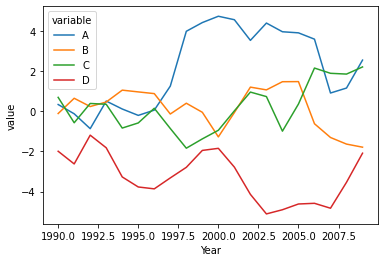

In [32]:
sns.lineplot(x='Year', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Year']))

In [56]:
test = pd.pivot_table(df_top10[df_top10['chart'] == 'top200'][['date', 'artist', 'rank']], index = 'date', values = ['rank'], columns = 'artist').reset_index().droplevel(level=0, axis =1)
test.rename({'':'date'}, axis = 1, inplace=True)
test.head()

artist,date,Ariana Grande,Billie Eilish,Drake,Juice WRLD,Khalid,Lil Uzi Vert,Post Malone,Taylor Swift,Travis Scott,XXXTENTACION
0,2017-01-01,33.000,NaN,91.600,NaN,NaN,67.000,140.000,NaN,106.500,NaN
1,2017-01-02,68.000,NaN,108.333,NaN,190.000,91.250,113.000,NaN,128.000,NaN
2,2017-01-03,73.000,NaN,119.000,NaN,178.000,95.000,115.500,NaN,133.000,NaN
3,2017-01-04,98.000,NaN,120.000,NaN,178.000,90.000,118.000,NaN,127.000,NaN
4,2017-01-05,99.000,NaN,114.833,NaN,177.000,88.000,112.500,NaN,121.000,NaN


In [ ]:
sns.lineplot(x='Year', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Year']))

<AxesSubplot: >

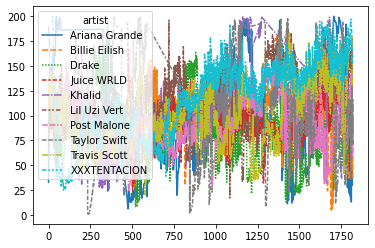

In [59]:
sns.lineplot(data = test)

# Music genre evolution

In [20]:
df

,title,rank,date,artist,url,region,chart,trend,streams,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,_merge
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000,"30 Jan 2018, 04:41","26 Jun 2013, 14:20","Migos is a rap trio-group from Lawrenceville, ...","Migos is a rap trio-group from Lawrenceville, ...",Hip-Hop,trap,rap,hip hop,atlanta,trap,Hip-Hop,rap,2010s,meme rap,spotify:track:0M9ydKzuF3oZTfYYPfaGX1,0.926,0.666,11.000,-5.314,1.000,0.244,0.061,0.000,0.123,0.168,127.079,audio_features,0M9ydKzuF3oZTfYYPfaGX1,https://api.spotify.com/v1/tracks/0M9ydKzuF3oZ...,https://api.spotify.com/v1/audio-analysis/0M9y...,343150.000,4.000,both
1,Fake Love,2,2017-01-01,Drake,https://open.spotify.com/track/343YBumqHu19cGo...,United States,top200,SAME_POSITION,1180074.000,"27 Oct 2016, 02:34","25 Mar 2006, 06:09","Aubrey Drake Graham (born October 24, 1986) is...","Aubrey Drake Graham (born October 24, 1986) is...",Hip-Hop,rap,rnb,hip hop,Canadian,trap,Hip-Hop,rap,hiphop,rnb,spotify:track:343YBumqHu19cGoGARUTsd,0.928,0.481,9.000,-9.350,0.000,0.287,0.105,0.000,0.176,0.613,134.007,audio_features,343YBumqHu19cGoGARUTsd,https://api.spotify.com/v1/tracks/343YBumqHu19...,https://api.spotify.com/v1/audio-analysis/343Y...,210937.000,4.000,both
2,Starboy,3,2017-01-01,"The Weeknd, Daft Punk",https://open.spotify.com/track/5aAx2yezTd8zXrk...,United States,top200,SAME_POSITION,1064351.000,NaN,"01 Jan 1970, 00:00","<a href=""https://www.last.fm/music/The+Weeknd...",,mistagged,Daft Punk,mistagged artist,The Weeknd,NaN,NaN,NaN,NaN,NaN,NaN,spotify:track:7MXVkk9YMctZqd1Srtv4MB,0.679,0.587,7.000,-7.015,1.000,0.276,0.141,0.000,0.137,0.486,186.003,audio_features,7MXVkk9YMctZqd1Srtv4MB,https://api.spotify.com/v1/tracks/7MXVkk9YMctZ...,https://api.spotify.com/v1/audio-analysis/7MXV...,230453.000,4.000,both
3,Closer,4,2017-01-01,"The Chainsmokers, Halsey",https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,United States,top200,SAME_POSITION,1010492.000,NaN,"01 Jan 1970, 00:00","<a href=""https://www.last.fm/music/The+Chains...",,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8.000,-5.599,1.000,0.034,0.414,0.000,0.111,0.661,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960.000,4.000,both
4,Black Beatles,5,2017-01-01,"Rae Sremmurd, Gucci Mane",https://open.spotify.com/track/6fujklziTHa8uoM...,United States,top200,SAME_POSITION,874289.000,NaN,"01 Jan 1970, 00:00","<a href=""https://www.last.fm/music/Rae+Sremmu...",,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spotify:track:6fujklziTHa8uoM5OQSfIo,0.794,0.632,0.000,-6.163,1.000,0.065,0.142,0.000,0.128,0.355,145.926,audio_features,6fujklziTHa8uoM5OQSfIo,https://api.spotify.com/v1/tracks/6fujklziTHa8...,https://api.spotify.com/v1/audio-analysis/6fuj...,291893.000,4.000,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456825,Bad Habits,46,2021-07-31,Ed Sheeran,https://open.spotify.com/track/6PQ88X9TkUIAUIZ...,United States,viral50,SAME_POSITION,NaN,"19 Jun 2021, 18:50","27 Jan 2008, 01:02","Edward Christopher ""Ed"" Sheeran MBE (born 17 F...","Edward Christopher ""Ed"" Sheeran MBE (born 17 F...",acoustic,british,singer-songwriter,easy-listening,pop,pop,2021,Ed Sheeran,2020s,dance,spotify:track:3rmo8F54jFF8OgYsqTxm5d,0.807,0.893,11.000,-3.745,0.000,0.035,0.045,0.000,0.366,0.537,126.011,audio_features,3rmo8F54jFF8OgYsqTxm5d,https://api.spotify.com/v1/tracks/3r